# Modelling

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [2]:
path = '../data/processed_customer_data.csv'

X = pd.read_csv(path)
print(X.dtypes, end = '\n--------------------------')
X

f_score      int64
m_score    float64
r_score      int64
dtype: object
--------------------------

,f_score,m_score,r_score
0,3,319.12,326
1,8,4821.69,2
2,5,1658.40,75
3,3,3545.69,19
4,1,294.40,310
...,...,...,...
5847,22,2655.75,4
5848,1,411.68,432
5849,1,372.60,661
5850,2,1207.63,477


## 1. EDA

Perform a final review of all features to identify potential patterns, correlations, or anomalies that could provide valuable insights or influence model performance before clustering.

In [5]:
X.skew().abs()

f_score    3.029541
m_score    3.870392
r_score    0.894319
dtype: float64

In [6]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
f_score,5852.0,5.761449,7.596842,1.00,1.000,3.000,7.00,46.0000
m_score,5852.0,2127.651591,3729.380079,2.95,329.405,833.655,2149.73,24942.1375
r_score,5852.0,200.198052,208.509570,1.00,25.000,95.000,379.00,739.0000


In [7]:
for col in X.columns:
    print(f'{col} : {X[col].quantile(0.95)}')

f_score : 20.0
m_score : 8618.5155
r_score : 623.4499999999998


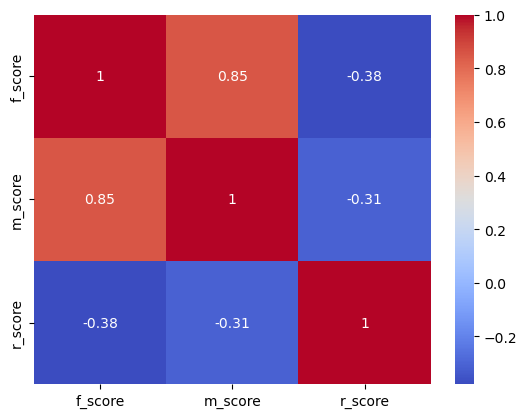

In [8]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

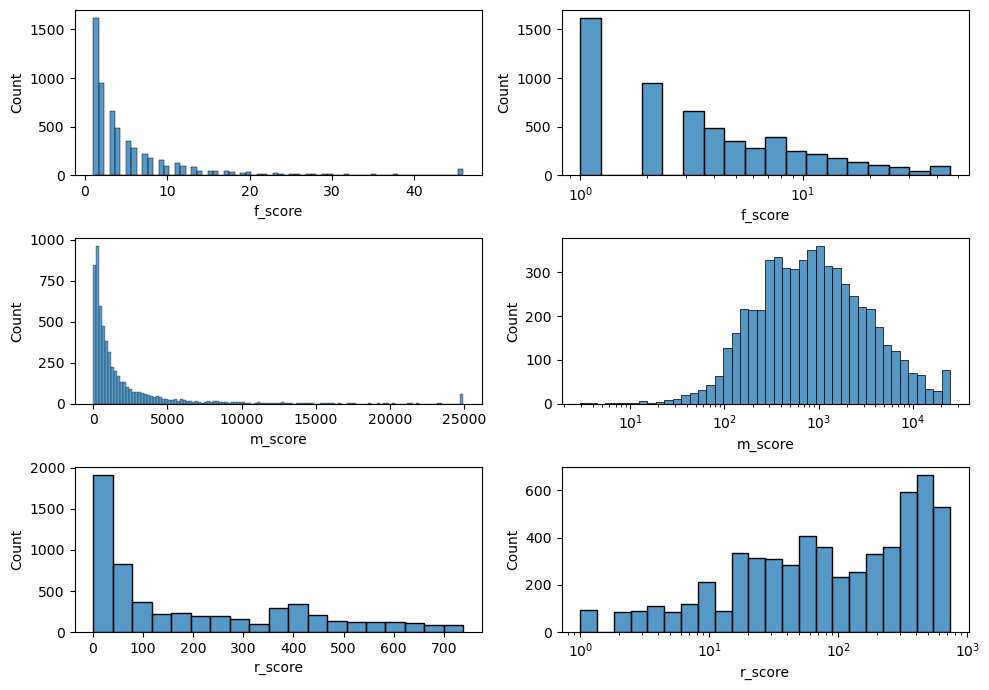

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(10, 7))

for i in range(3):
    col = X.iloc[:, i]
    sns.histplot(col, ax = ax[i,0])
    sns.histplot(col, ax = ax[i,1], log_scale = True)

plt.tight_layout()
plt.show()

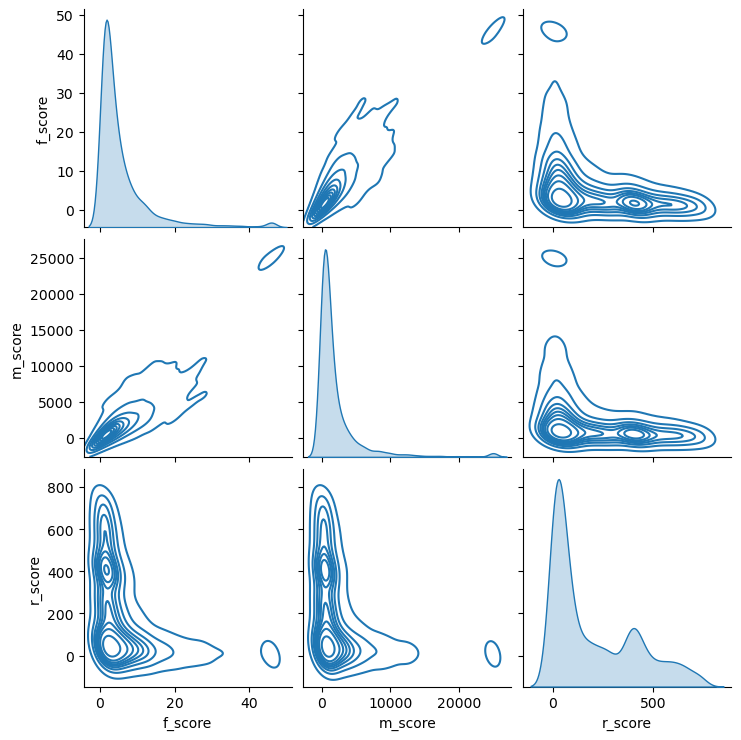

In [10]:
sns.pairplot(X, kind = 'kde')
plt.show()

**Conclusion**

The **RFM features** display strong right-skewness — particularly `f_score` and `m_score` — indicating that a small group of customers drives most transactions and revenue. Applying **log-scaling** reveals clearer and more interpretable distributions (see histograms).

* **Correlation analysis:**
  The heatmap shows a **strong positive correlation (≈ 0.85)** between `m_score` and `f_score`, suggesting that frequent buyers also tend to spend more.
  In contrast, `r_score` (recency) has a **negative correlation** with both, meaning that recent customers are often less active or high-spending.

* **Distribution insights:**
  After visualizing both **linear** and **log-scaled histograms**, the data exhibits a **heavy-tailed pattern** — many low-value customers and few very high-value ones (typical for retail datasets).
  KDE pairplots further confirm **cluster tendencies**: dense cores around low values with scattered high-value outliers, indicating potential segments like *loyal high spenders* vs. *occasional buyers*.

Overall, the data is ready for modeling after **log transformation and scaling of features with skew > 1**, with clear behavioral patterns already visible.


## Preprocessing Pipeline

As observed earlier, all features except **`r_score`** are highly skewed. Therefore, we will apply **`RobustScaler()`** instead of **`StandardScaler()`** to reduce the influence of extreme values.

To further stabilize distributions and handle residual outliers, the skewed features will be **log1p-transformed** before scaling.

> This means part of the preprocessing will be integrated directly into the **modeling pipeline**, ensuring consistent transformation during both training and prediction stages.

First create pipline for rescaling data and handling outliers

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer


skew = X.skew(numeric_only=True).abs().sort_values(ascending=False)
skewed_cols = skew[skew >= 1].index.tolist()          # ['m_score','f_score'] in this case
near_normal_cols = skew[(skew < 1)].index.tolist()    # ['r_score'] in this case

#  Pipeline for skewed features
skew_pipe = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')), # Wrap log-function in a transrotmer
    ('scale', RobustScaler()) # 
])

# Pipeline for nearly normal features
normal_pipe = Pipeline([
    ('scale', StandardScaler())
])

# Combine to one pipeline
preprocess = ColumnTransformer([
    ('skew',   skew_pipe,  skewed_cols),
    ('normal', normal_pipe, near_normal_cols)
], remainder='drop')

preprocess

ColumnTransformer(transformers=[('skew',
                                 Pipeline(steps=[('log1p',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scale', RobustScaler())]),
                                 ['m_score', 'f_score']),
                                ('normal',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['r_score'])])

Since the dataset contains only **three features**, applying dimensionality reduction is unnecessary. We proceed directly to **model selection** to maintain a simple and interpretable clustering workflow.


## Model Selection

In [18]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
f_score,5852.0,5.761449,7.596842,1.00,1.000,3.000,7.00,46.0000
m_score,5852.0,2127.651591,3729.380079,2.95,329.405,833.655,2149.73,24942.1375
r_score,5852.0,200.198052,208.509570,1.00,25.000,95.000,379.00,739.0000


In [19]:
scaled = preprocess.fit_transform(X)
X_scaled = pd.DataFrame(scaled)

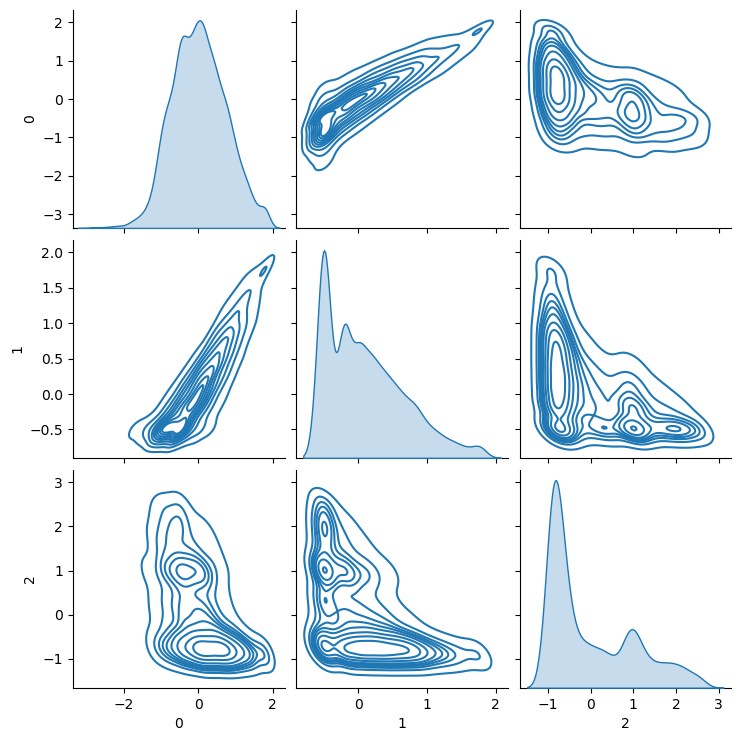

In [20]:
sns.pairplot(X_scaled, kind = 'kde')
plt.show()

In [21]:
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5852.0,1.908919e-02,0.719538,-2.857772,-0.494703,0.000000,0.505297,1.813611
1,5852.0,1.119419e-01,0.568250,-0.500000,-0.500000,0.000000,0.500000,1.777294
2,5852.0,-2.306957e-17,1.000085,-0.955424,-0.840312,-0.504567,0.857597,2.584284


We selected two clustering models for evaluation:

* **K-Means** — chosen for its simplicity and efficiency in detecting compact, well-separated customer clusters based on Euclidean distance, serving as a solid baseline for RFM segmentation.
* **Gaussian Mixture Model (GMM)** — extends K-Means by allowing elliptical cluster shapes and soft (probabilistic) memberships, capturing more nuanced and overlapping customer behaviors.

To evaluate clustering quality, we use **Silhouette**, **Calinski–Harabasz**, and **Davies–Bouldin** scores — together they measure **separation**, **compactness**, and **overall structure**, offering a balanced, unsupervised comparison of model performance.

In [23]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Create model grid to iterate
grids = [
    {
        'model': [KMeans()],
        'model__n_clusters': range(3,7), # k : 2-10
        'model__n_init': [15,20]
    },
    {
        'model': [GaussianMixture()],
        'model__n_components': range(3,7), # k : 2-10
        'model__covariance_type': ['full','diag'] # different covariance types
    },
] 

Use `ParameterGrid()` to grid-search model hyperparameters across **K-Means** and **GMM**, evaluate each run (**Silhouette, Calinski–Harabasz, Davies–Bouldin**), and select the best-scoring configuration.


In [25]:
from sklearn.model_selection import ParameterGrid

results = [] 

param_grid = list(ParameterGrid(grids))

for params in ParameterGrid(grids):
    model = params['model']
    model.set_params(**{k.replace('model__', ''): v for k, v in params.items() if k != 'model'})
    
    # fit preprocess on full X once per run, then transform for metrics & model
    X_t = preprocess.fit_transform(X)

    # fit model on transformed space
    model.fit(X_t)
    labels = model.predict(X_t)

    #skip unvaliable clusters
    if len(set(labels)) <= 1:
        continue

    # metrics computed on transformed space
    sil = silhouette_score(X_t, labels)
    ch  = calinski_harabasz_score(X_t, labels)
    db  = davies_bouldin_score(X_t, labels)

    results.append({
        'model': model.__class__.__name__,
        'params': {k: v for k,v in params.items() if k!='model'},
        'silhouette': sil, 'ch': ch, 'db': db,
        'n_clusters': len(set(labels)),
    })

In [26]:
results_df = pd.DataFrame(results).sort_values('silhouette', ascending = False).reset_index(drop = True)
results_df

,model,params,silhouette,ch,db,n_clusters
0,KMeans,"{'model__n_clusters': 3, 'model__n_init': 15}",0.426585,7313.950871,0.805166,3
1,KMeans,"{'model__n_clusters': 3, 'model__n_init': 20}",0.426585,7313.950871,0.805166,3
2,KMeans,"{'model__n_clusters': 4, 'model__n_init': 20}",0.390325,6532.306840,0.916337,4
3,KMeans,"{'model__n_clusters': 4, 'model__n_init': 15}",0.388951,6532.277089,0.925518,4
4,KMeans,"{'model__n_clusters': 6, 'model__n_init': 20}",0.355012,6347.636073,0.928279,6
5,KMeans,"{'model__n_clusters': 6, 'model__n_init': 15}",0.354983,6347.591232,0.928381,6
6,KMeans,"{'model__n_clusters': 5, 'model__n_init': 20}",0.350514,6438.647597,0.944484,5
7,KMeans,"{'model__n_clusters': 5, 'model__n_init': 15}",0.350464,6438.643891,0.944601,5
8,GaussianMixture,"{'model__covariance_type': 'diag', 'model__n_c...",0.306129,4087.198650,0.889056,3
9,GaussianMixture,"{'model__covariance_type': 'diag', 'model__n_c...",0.221903,2975.999815,1.410096,4


Based on the comparison results, **K-Means (`n_clusters = 3`, `n_init = 15`)** achieved the **highest Silhouette score (0.43)** and the **lowest Davies–Bouldin index**, outperforming all GMM configurations and other K-Means variants.

Although **K-Means (`n_init = 20`)** performed similarly, we selected the simpler **best-performing model** for final segmentation.

## Model Validation

Build the **final K-Means model (`n_clusters = 3`, `n_init = 15`)** and assign cluster labels to each customer.  

In [30]:
best_model = KMeans(n_clusters=3, n_init=20)
final_pipeline = Pipeline([
    ('preprocess', preprocess), 
    ('model', best_model)
])
final_pipeline.fit(X)
df = X.copy()
df['cluster'] = final_pipeline.predict(X)

Then, create a **visual segmentation report**  to interpret cluster characteristics and identify the main customer segments based on their **Recency**, **Frequency**, and **Monetary** profiles.

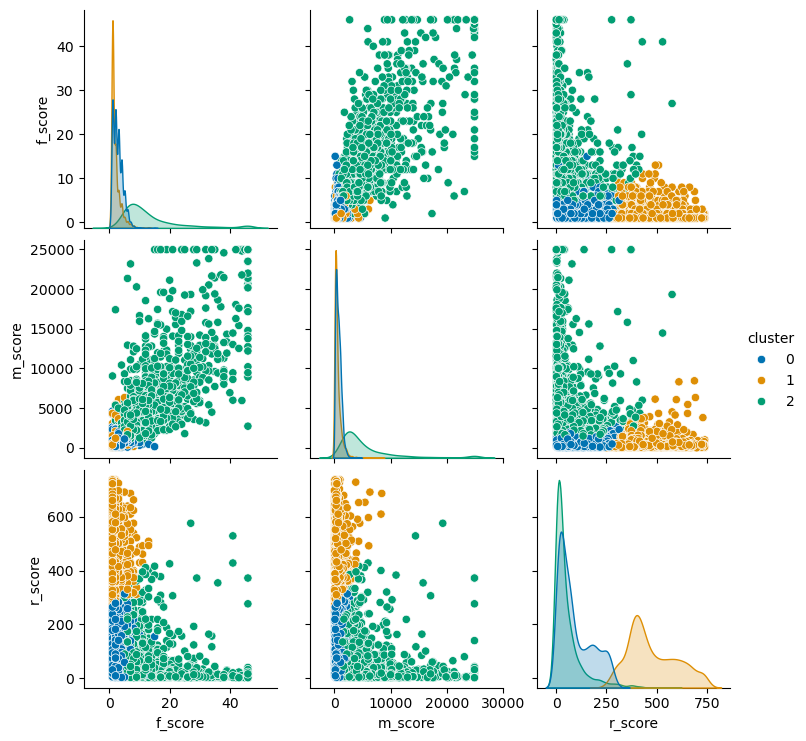

In [31]:
sns.pairplot(df, kind = 'scatter', hue = 'cluster', palette = 'colorblind')
plt.show()

In [32]:
profile = (
    df.groupby('cluster')[['r_score','f_score','m_score']]
      .agg(['count','mean','median'])
      .sort_values(('m_score','mean'), ascending=False)
)
profile

r_score                    f_score                   m_score  \
          count        mean median   count       mean median   count   
cluster                                                                
2          1778   52.276153   26.0    1778  13.466817   10.0    1778   
0          2251   93.358507   64.0    2251   2.731675    2.0    2251   
1          1823  476.391662  438.0    1823   1.987383    1.0    1823   

                               
                mean   median  
cluster                        
2        5527.237060  3545.29  
0         703.154100   615.14  
1         570.921415   344.14

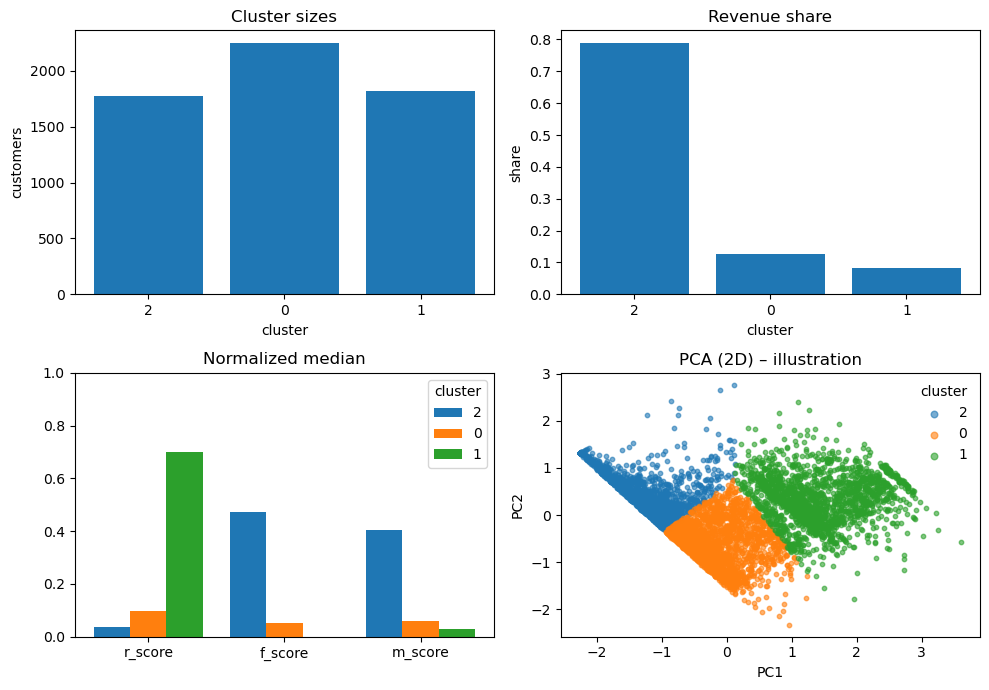

In [37]:
from sklearn.decomposition import PCA

kpi = ['r_score','f_score','m_score']

# Orrder clusters by monetary median 
order = (df.groupby('cluster')['m_score'].median()
         .sort_values(ascending=False).index.tolist())

# Compute metrics
sizes = df['cluster'].value_counts().reindex(order)
revenue = df.groupby('cluster')['m_score'].sum().reindex(order)

# Normalized medians (robust 5–95% scaling)
med = df.groupby('cluster')[kpi].median().reindex(order)
q05, q95 = df[kpi].quantile(0.05), df[kpi].quantile(0.95)
med_norm = ((med - q05) / (q95 - q05 + 1e-9)).clip(0,1)

# PCA on preprocessed features (visual only)
X_t = preprocess.fit_transform(df[kpi])  
pca_values = PCA(n_components=2, random_state=42).fit_transform(X_t)
pca_pd = pd.DataFrame(pca_values, columns=['pc1','pc2']).assign(cluster=df['cluster'].values)


fig, ax = plt.subplots(2, 2, figsize=(10, 7))

# Sizes
ax[0,0].bar(list(map(str, order)), sizes.values)
ax[0,0].set_title('Cluster sizes'); ax[0,0].set_xlabel('cluster'); ax[0,0].set_ylabel('customers')

# Revenue share
ax[0,1].bar(list(map(str, order)), (revenue/revenue.sum()).values)
ax[0,1].set_title('Revenue share'); ax[0,1].set_xlabel('cluster'); ax[0,1].set_ylabel('share')

# 3) normalized medians
x = np.arange(len(kpi)); w = 0.8/len(order)
for i,c in enumerate(order):
    ax[1,0].bar(x + i*w, med_norm.loc[c].values, width=w, label=f'{c}')
ax[1,0].set_xticks(x + w*(len(order)-1)/2); ax[1,0].set_xticklabels(kpi)
ax[1,0].set_ylim(0,1); ax[1,0].set_title('Normalized median'); ax[1,0].legend(title='cluster')

# PCA scatter
for c in order:
    cluster_rows = pca_pd[pca_pd['cluster']==c]
    ax[1,1].scatter(cluster_rows['pc1'], cluster_rows['pc2'], s=10, alpha=0.6, label=f'{c}')
ax[1,1].set_title('PCA (2D) – illustration'); ax[1,1].set_xlabel('PC1'); ax[1,1].set_ylabel('PC2')
ax[1,1].legend(title='cluster', markerscale=1.5, frameon=False)

plt.tight_layout()
plt.show()

### **Customer Segmentation Summary**

Using the best model (**K-Means, n_clusters = 3, n_init = 15**), three clear customer groups were identified.


#### **Cluster Overview**

**Pairplot** (Fig. 1) shows distinct separation by **Recency**, **Frequency**, and **Monetary**:

* **Cluster 2 (green):** frequent, high-spending buyers.
* **Cluster 0 (blue):** average, moderately active customers.
* **Cluster 1 (orange):** inactive, low-spending customers.


#### **Cluster Statistics**

**Cluster 2** leads in frequency and spend; **Cluster 1** shows the worst recency.
**Cluster 0** lies between the two, forming the largest share of users.


#### **Segment Insights**

Visual metrics (Fig. 3) confirm:

* **Cluster 2 – “Champions”**: ~30 % of users, ~80 % of revenue.
* **Cluster 0 – “Potential Loyalists”**: stable, mid-value buyers.
* **Cluster 1 – “Dormant”**: long inactive, low-value customers.


### **Conclusion**

The model defines **three actionable customer segments**:
retain **Champions**, nurture **Loyalists**, and re-engage **Dormant** users.


## 5. Export model

In [64]:
import joblib

joblib.dump(final_pipeline, "../model/final_segmentation_pipeline.joblib")
print('model exported successfully')

model exported successfully
